## Explainable AI: Lime und Saliency Maps

In der heutigen Übung möchten wir zwei Modelle trainieren:
1) Modell zur Vorhersage von Hauspreisen
2) Modell zur Klassifikation von Bildern

Wir möchten ExplainableAI Methoden nutzen, um ein Verständnis über die Funktionsweise der Modelle und vor allem eine Erklärung für Nutzende zu ermöglichen. Wir interpretieren einerseits selbst die Ausgaben und nutzen andererseits LLMs.

In [1]:
# workaround to show html rendering in VSCode notebooks
import sys
from IPython import display
sys.modules['IPython.core.display'] = display

### Modell zur Vorhersage von Hauspreisen

In Übung 2 haben wir bereits mit folgendem Datensatz gearbeitet: https://www.kaggle.com/datasets/yasserh/housing-prices-dataset/data (License: CCO: Public Domain).

Lade ihn von Kagglehub herunter, exploriere und lade ihn in ein Pandas Dataframe. Der Dataframe soll der Variablen ```df``` zugewiesen werden.

In [2]:
import kagglehub
import os

os.environ['KAGGLEHUB_CACHE'] = 'data'
path = kagglehub.dataset_download("yasserh/housing-prices-dataset")

print("Path to dataset files:", path)

/Users/winkelmannsv/git/aki/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: data/datasets/yasserh/housing-prices-dataset/versions/1


In [3]:
import pandas as pd

df = pd.read_csv(os.path.join(path, 'housing.csv'))
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [4]:
print(f"Unser Datensatz hat {df.shape[0]} Samples mit {df.shape[1]-1} Features.")

Unser Datensatz hat 545 Samples mit 12 Features.


In [5]:
df.dtypes

price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object

Wir sehen, dass einige Werte als object (bzw. String) vorliegen. Das mag unser Machine Learning Modell nicht, deswegen müssen wir zuerst die String-Werte in Zahlen (int) transformieren. In der Regel nimmt man für no=0 und yes=1. Bei mehreren Kategorien, wie zum Beispiel bei ```df['funishingstatus']``` zählen wir die Zahlen einfach hoch. Für das Ersetzen im Datensatz können wir die Funktion ```df.replace``` nutzen:

In [6]:
df['furnishingstatus'].unique()

array(['furnished', 'semi-furnished', 'unfurnished'], dtype=object)

In [7]:
pd.set_option("future.no_silent_downcasting", True)
df = df.replace({"no": 0, "yes": 1})
df = df.replace({"unfurnished": 0, "semi-furnished": 1, "furnished": 2})

In [8]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,2
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,2
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,2
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,2


Wie im Vorlesungsbeispiel splitten wir den Datensatz in:
1) x: abhängigen Variablen, d.h. alle Features auf welchen unser Modell trainieren soll
2) y: unabhängige Variablen, d.h. das Feature, welches unser Modell vorhersagen soll

In [9]:
# splitting the data into independent and dependent variables
x = df.drop(columns=['price'])
y = df['price'] # we want to predict the house price

# dividing the dataset into training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [10]:
# building the model
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [11]:
# fitting the training data
model.fit(x_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(x_test)

# Metriken berechnen
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Metriken ausgeben
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R²-Score: {r2:.2f}")

Mean Absolute Error (MAE): 919520.65
Mean Squared Error (MSE): 1560062846482.42
R²-Score: 0.66


### Lime zur Erklärung von Hauspreis-Prognosen

Wie in der Vorlesung möchten wir nun einen Hauspreis auf Basis der 12 Features vorhersagen lassen und mit Lime eine Übersicht bekommen welche Features wie auf den Preis eingewirkt haben. 

Passen Sie den Code aus der Vorlesung so an, dass es für ein Regressions-Modell funktioniert:

In [13]:
import lime
import numpy as np

from lime import lime_tabular


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

lime_explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(x_train), 
                                                    feature_names=x_train.columns, 
                                                    mode='regression',
                                                    random_state=42)

Wir lassen uns für den ersten Datenpunkt im Testdatensatz den Preis berechnen und erklären. Sie können natürlich auch beliebige Werte ausprobieren.

In [14]:
x_test.iloc[0]

area                5900
bedrooms               4
bathrooms              2
stories                2
mainroad               0
guestroom              0
basement               1
hotwaterheating        0
airconditioning        0
parking                1
prefarea               0
furnishingstatus       0
Name: 316, dtype: object

Passen Sie den Code aus der Vorlesung auf dieses Modell an:

In [15]:
explanation = lime_explainer.explain_instance(data_row=x_test.iloc[1], predict_fn=model.predict, num_features=12)
explanation.show_in_notebook(show_table = True, show_all = True)

/Users/winkelmannsv/git/aki/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


### Modell zur Klassifikation von Bildern

Im folgenden nutzen wir ein vortrainiertes vgg16 Modell, welches auf Basis des ImageNet Datensatzes trainiert wurde und 1000 Klassen unterscheiden kann. 

Based on: https://keisen.github.io/tf-keras-vis-docs/examples/attentions.html

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
model = keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Wir laden uns drei JPG Bilder aus dem Ordner imgs. Nutzen Sie gerne eigene Bilder und probieren verschiedene Klassen durch.

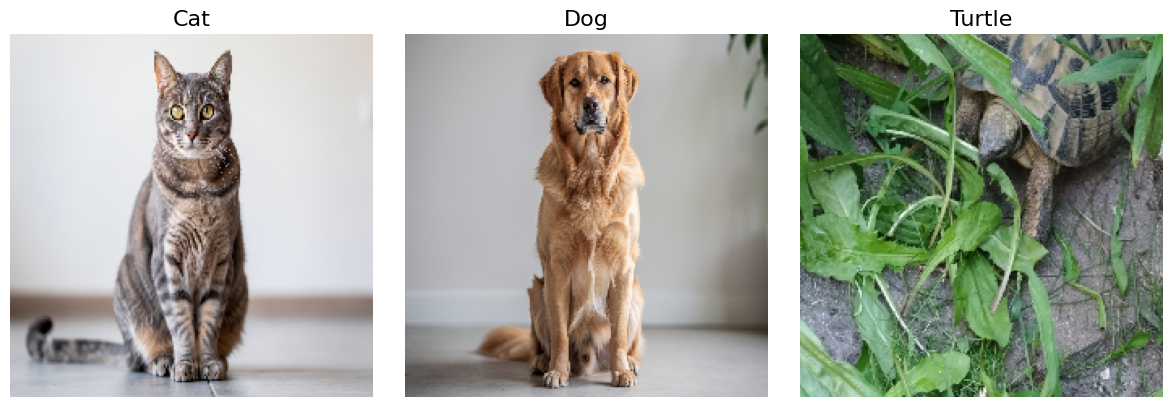

In [3]:
import os
from keras.preprocessing import image
image_titles = ['Cat', 'Dog', 'Turtle']

# cat and dog images are generated by Mistral Medium 3.1
img1 = keras.preprocessing.image.load_img(os.path.join('imgs', '9-cat.jpg'), target_size=(224, 224))
img2 = keras.preprocessing.image.load_img(os.path.join('imgs', '9-dog.jpg'), target_size=(224, 224))
img3 = keras.preprocessing.image.load_img(os.path.join('imgs', '2-turtle.JPG'), target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

# Rendering
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

Um ein gutes Ergebnis zu erreichen müssen wir die Bilder durch einen vgg16 spezifische Vorverarbeitung schicken. Dabei werden sie normalisiert und auf den richtigen Wertebereich angepasst. Anschließend sagt das Modell mit ```model.predict(np.asarray(X))``` für alle Bilder die Klassen vorher. 

In [ ]:
# Preparing input data for VGG16
X = keras.applications.vgg16.preprocess_input(images)

predictions = model.predict(np.asarray(X))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Unser Modell gibt uns für jedes Bild jeweils 1000 Werte aus. Für jede Klasse aus dem ImageNet Datensatz wird ein Wert ausgegeben, je höher dieser ist, desto eher gehört das Bild zur entsprechenden Klasse. Eine Übersicht über alle Klassen finden Sie hier: https://gist.github.com/maraoz/388eddec39d60c6d52d4

Über ```np.argmax``` wählen wir die Klasse mit dem höchsten Prediction Wert aus. 

In [13]:
classes = [np.argmax(predictions[0]), np.argmax(predictions[1]), np.argmax(predictions[2])]

for i in range(len(image_titles)):
    print(f"Prediction {i}. Bild: ", classes[i])

Prediction 0. Bild:  285
Prediction 1. Bild:  207
Prediction 2. Bild:  305


### Saliency Maps

Nun möchten wir verdeutlichen welche Teile des Bilds für das Modell wichtig und welche nicht wichtig zur Klassifikation der drei Bilder sind. Im folgenden nutzen wir die jeweiligen Attentions aus der Lib ```tf-keras-vis```: https://keisen.github.io/tf-keras-vis-docs/examples/attentions.html.

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

replace2linear = ReplaceToLinear()
score = CategoricalScore(classes)

Im folgenden ist einfach der Code von GradCam hier reinkopiert. Probieren Sie verschiedene Attribution Methoden aus!

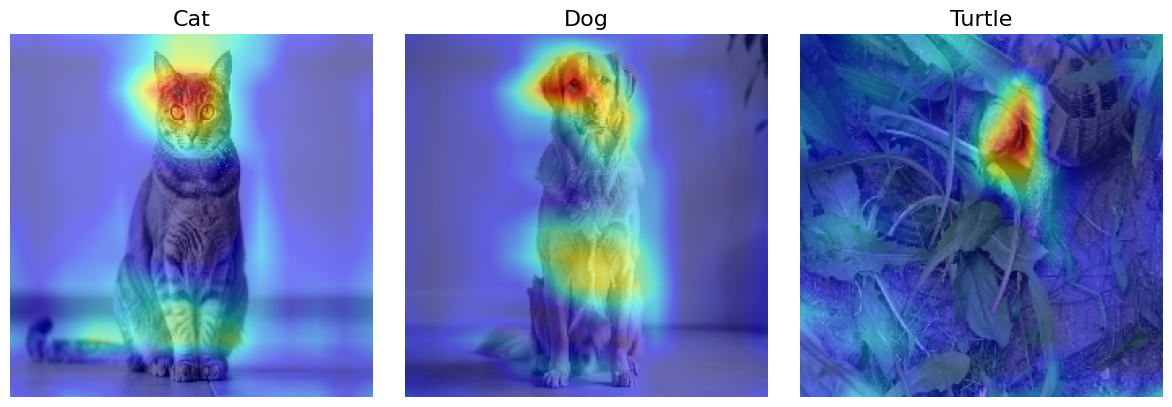

CPU times: user 5.83 s, sys: 779 ms, total: 6.61 s
Wall time: 1.36 s


In [9]:
%%time

from matplotlib import cm

from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model, model_modifier=replace2linear, clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score, X, penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)  # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

Nutzen Sie ein LLM Ihrer Wahl, um sich die Ausgabe erklären zu lassen. Bei Mistral hat folgender Prompt ganz gut funktioniert:

"Wir haben ein VGG16 Modell zur Bildklassifikation auf Basis der ImageNet Klassen. Das Modell hat die Klassen Egyptian cat vorhergesagt. Die Ausgabe von tf_keras_vis.gradcam ist das Bild im Anhang. Erkläre mir was dies zu bedeuten hat."

### Ausgabe von Mistral:

Das Bild, das du hochgeladen hast, ist eine Grad-CAM (Gradient-weighted Class Activation Mapping)-Visualisierung. Diese Technik wird verwendet, um zu verstehen, welche Bereiche eines Bildes am stärksten zur Klassifizierungsentscheidung eines neuronalen Netzes beigetragen haben. Hier ist eine detaillierte Erklärung, was das bedeutet und wie du die Visualisierung interpretieren kannst:

#### Was ist Grad-CAM?

Grad-CAM ist eine Methode, um die Aufmerksamkeit eines Convolutional Neural Networks (CNN) wie VGG16 auf bestimmte Bildbereiche zu visualisieren.
Es kombiniert die Gradienten (Ableitungen) der Zielklasse (hier: "Egyptian cat") mit den Feature-Maps der letzten Convolutional-Schicht des Modells.
Das Ergebnis ist eine Heatmap, die zeigt, welche Bildbereiche für die Klassifizierung am wichtigsten waren.

#### Interpretation deiner Grad-CAM


1) Farben und Intensität:
- Rote/Gelbe Bereiche: Diese Bereiche haben den stärksten Einfluss auf die Klassifizierung als "Egyptian cat". Das Modell hat sich besonders auf den Kopf und die Augen der Katze konzentriert.
- Blaue/Lila Bereiche: Diese Bereiche haben kaum oder keinen Einfluss auf die Klassifizierung.


2) Kopf und Augen:
- Die Grad-CAM zeigt, dass das Modell die Augen, Ohren und den Kopf der Katze als entscheidend für die Klassifizierung als "Egyptian cat" identifiziert hat. Das ist sinnvoll, da diese Merkmale oft charakteristisch für Katzenrassen sind.

3) Körper und Hintergrund:

- Der Körper der Katze und der Hintergrund sind kaum hervorgehoben, was bedeutet, dass sie für die Klassifizierung weniger relevant waren.


#### Warum ist das nützlich?

- Modellinterpretation: Grad-CAM hilft dir zu verstehen, welche visuellen Merkmale das Modell gelernt hat, um eine bestimmte Klasse zu erkennen.
- Fehleranalyse: Falls das Modell eine falsche Klassifizierung vornimmt, kann Grad-CAM zeigen, welche Bildbereiche das Modell fälschlicherweise als relevant eingestuft hat.
- Vertrauen: Es erhöht das Vertrauen in das Modell, wenn die hervorgehobenen Bereiche mit menschlichen Intuitionen übereinstimmen (z. B. Kopf und Augen für eine Katze).

#### Technische Details

- Letzte Convolutional-Schicht: Grad-CAM nutzt die Feature-Maps der letzten Convolutional-Schicht (bei VGG16 ist das die Schicht block5_conv3).
- Gradienten: Die Gradienten der Zielklasse werden rückwärts durch das Netz propagiert, um die Wichtigkeit jeder Feature-Map zu berechnen.
- Heatmap: Die Heatmap wird durch eine gewichtete Kombination der Feature-Maps erzeugt und auf das Originalbild projiziert.


## Die Frage der Fragen: was passiert nun, wenn wir ein Bild mit mehreren Objekten in das Modell geben :)? Probieren Sie es z.B. mal mit einem Bild von einem Hund und einer Katze aus!